In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt
import os

# Setup Compartments with NxNet C API

NxNet C API provides a way to access compartments and compartment groups through SNIP C-code. In this tutorial, we demonstrate how to use NxNet C API to setup compartments. For more details about NxNet C API, please refer to the documentation.

<img src="../figures/jupyter_tutorial_nxnet_c_api.png">

In the below code, two compartment prototypes are created on different logicalCoreId. This is just for illustrative purpose, and it is not required that two compartments need to be on seperate cores.

In [3]:
net = nx.NxNet()

# create a compartment prototype for cx0 whose parameter values are to be set in initsnip
cxp0 = nx.CompartmentPrototype(functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               refractoryDelay=2,
                               logicalCoreId=0)

# create a compartment prototype for cx1 
cxp1 = nx.CompartmentPrototype(biasMant=100,
                               biasExp=6,
                               compartmentVoltageDecay=15,
                               refractoryDelay=2,
                               vThMant=1000,
                               functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                               logicalCoreId=1)

# Create compartmentGroup from the two different prototypes
cxGrp = net.createCompartmentGroup(size=2, prototype=[cxp0, cxp1], prototypeMap=[0, 1])

## Configure voltage and spike probes

In [4]:
(vProbes, sProbes) = cxGrp.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE, nx.ProbeParameter.SPIKE])

## Compile network

In [5]:
compiler = nx.N2Compiler()
board = compiler.compile(net)

## Configure SNIP and channels 

In [6]:
# Define directory where SNIP C-code is located
includeDir = os.getcwd()

# create a SNIP to initialize cx0. This SNIP will execute initsnip.c in init phase of the NxRuntime execution cycle
initProcess = board.createProcess("initProcess",
                                  includeDir=includeDir,
                                  cFilePath=includeDir + "/initsnip.c",
                                  funcName="initParams",
                                  guardName=None,
                                  phase = "init")
initChannel = board.createChannel(b'nxinit', "int", 1)
initChannel.connect(None, initProcess)

# create a SNIP to set parameters for the whole cxGrp, and to set refractoryDelay that is specific to cx1
# This SNIP will execute setParams.c in mgmt phase and only when guard (doSetting) is on
settingSnip = board.createProcess(name="setting",
                                 includeDir=includeDir,
                                 cFilePath=includeDir + "/setParams.c",
                                 funcName="setParams",
                                 guardName="doSetting",
                                 phase="mgmt")
settingChannel = board.createChannel(b'settingChannel', "int", 1)
settingChannel.connect(None, settingSnip)

board.startDriver()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861


## Execute network and send refractoryDelay value

In [7]:
# set new refractoryDelay value for cx1, which will take effect at time step 180, which is controlled by settingSnip.
# Please refer to setParams.c for more details.
refractoryDelay = [15]
settingChannel.write(1, refractoryDelay)

board.run(250, aSync=True)

board.finishRun()
board.disconnect()

## Visualize results

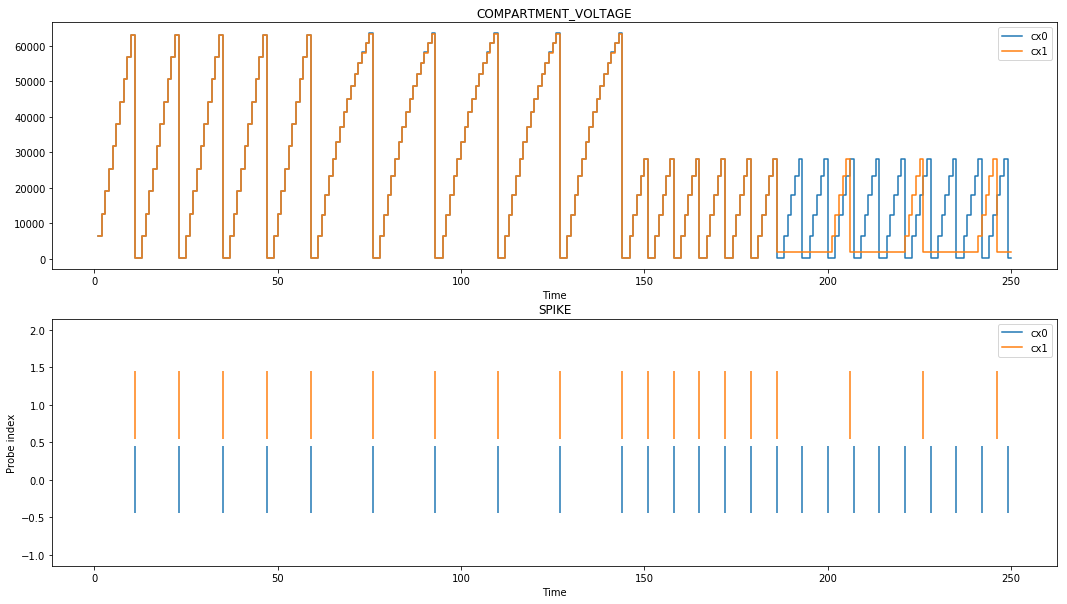

In [8]:
fig = plt.figure(1, figsize=(18,10))
# Plot compartment voltage
ax0 = plt.subplot(2,1,1)
vh = vProbes.plot()
# Plot compartment spikes
ax1 = plt.subplot(2,1,2)
sh = sProbes.plot(colors=[vh[0].get_color(), vh[1].get_color()])
ax1.set_xlim(ax0.get_xlim())
ax0.legend(vh, ['cx0', 'cx1'])
ax1.legend(vh, ['cx0', 'cx1'])
plt.show()
# cx0 and cx1 are initialized with the same parameter values, except for logicalCoreId. As can be seen below, the 
# compartment_voltage and spike for both cx0 and cx1 are the same from time 0. At time step 60, a new compartmentVoltageDecay
# value is set (via settingSnip) for the whole cxGrp, the firing rate for both cx0 and cx1 gets decreased. At time step 150, 
# a new vThMant value is set (via settingSnip) for cxGrp, the firing rate for cx0 and cx1 changes again. At time step 180, 
# a new refractoryDelay value is set (via settingSnip) for cx1 only. As shown in the figure below, only cx1 changes the firing
# pattern, while there is no more change for cx0.